In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

from src.ksd.models import create_mixture_gaussian
from src.ksd.langevin import RandomWalkMH

from src.ksd.ksd import KSD
from src.ksd.kernel import RBF, IMQ

# Metropolis-Adjusted Langevin dynamics

In [2]:
tf.random.set_seed(0)

In [3]:
delta = 4.
n = 500
dim = 5

target = create_mixture_gaussian(dim=dim, delta=delta)
one_component_mean = - delta * tf.eye(dim)[:, 0]

proposal_off = tfd.MultivariateNormalDiag(one_component_mean)
# proposal_off = tfd.MultivariateNormalDiag(0.*one_component_mean, 6*tf.ones(dim))
proposal_on = create_mixture_gaussian(dim=dim, delta=delta)

2022-02-09 18:00:34.734676: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-09 18:00:35.306230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:db:00.0, compute capability: 7.5


In [4]:
off_samples = proposal_off.sample(n)
on_samples = proposal_on.sample(n)

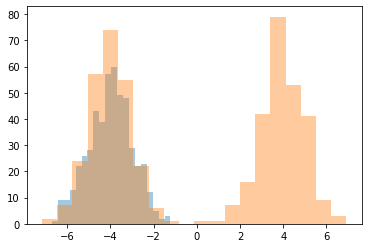

In [5]:
_ = plt.hist(off_samples.numpy()[:, 0], bins=20, label="off-target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)

In [6]:
def log_prob_fn(x):
    exp1 = tf.reduce_sum((x - one_component_mean)**2, axis=-1) # n
    exp2 = tf.reduce_sum((x + one_component_mean)**2, axis=-1) # n
    return tf.math.log(
        tf.math.exp(- 0.5 * exp1) + tf.math.exp(- 0.5 * exp2)
    )

mh_off = RandomWalkMH(log_prob=log_prob_fn)

In [7]:
steps = 2
std = 5.
x_init_off = tf.identity(off_samples)
dir_vec = tf.eye(dim)[:, 0]

mh_off.run(steps=steps, std=std, x_init=x_init_off, verbose=True, dir_vec=dir_vec)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 92.31it/s]


In [8]:
# check if the hard-coded log_prob equals to the built-in fn
diff = log_prob_fn(x_init_off) - proposal_on.log_prob(x_init_off)
tf.experimental.numpy.allclose(diff, diff[0])

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [9]:
def plot_steps(plot_t_step, result):
    nplots = steps // plot_t_step
    nrows = max(2, int(np.sqrt(nplots)))
    ncols = max(2, int(np.ceil(nplots / nrows)))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*nrows, 3*ncols))

    ind = 0
    t = 0
    for row in ax:
        for col in row:
            if ind >= nplots: break

            col.hist(result.x.numpy()[t, :, 0], bins=40, label="updated off-target", alpha=0.4)
            col.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)
            
    #         res_df = pd.DataFrame({"x": result.x.numpy()[t, :, 0], "type": "updated off-target"})
    #         res_df2 = pd.DataFrame({"x": on_samples.numpy()[:, 0], "type": "target"})
    #         res_df = pd.concat([res_df, res_df2], ignore_index=True)
    #         sns.ecdfplot(ax=col, data=res_df, hue="type", x="x", alpha=0.4)
    #         col.legend()
            col.set_title(f"t = {t}")

            if t == 0:
                col.legend()

            ind += 1
            t += plot_t_step

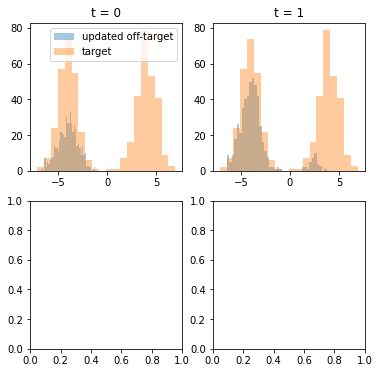

In [10]:
plot_t_step = 1 # plot every xxx steps
plot_steps(plot_t_step=plot_t_step, result=mh_off)

In [11]:
mh_on = RandomWalkMH(log_prob=proposal_on.log_prob)

x_init_on = tf.identity(on_samples)
mh_on.run(steps=steps, std=std, x_init=x_init_on, dir_vec=dir_vec)

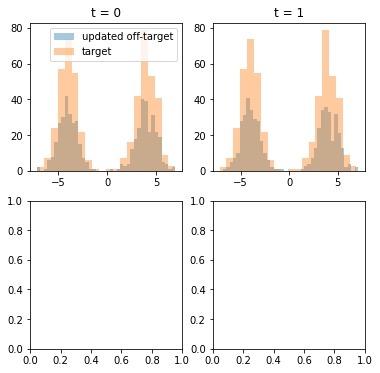

In [12]:
plot_steps(plot_t_step=plot_t_step, result=mh_on)

# KSD as a function of number of steps

In [24]:
tf.random.set_seed(0)

In [25]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

nrep = 5

In [26]:
def run_mh_experiment(nrep, proposal_off, proposal_on, steps, std):
    ksd_df = pd.DataFrame(columns=["t", "ksd", "seed", "type"])

    iterator = trange(nrep)
    for seed in iterator:
        off_samples = proposal_off.sample(n)
        on_samples = proposal_on.sample(n)
        
        x_init_off = off_samples
        x_init_on = on_samples

        mh_off = RandomWalkMH(log_prob=log_prob_fn)
        mh_off.run(steps=steps, std=std, x_init=x_init_off)

        mh_on = RandomWalkMH(log_prob=log_prob_fn)
        mh_on.run(steps=steps, std=std, x_init=x_init_on)

        for t in range(steps):
            iterator.set_description(f"Time step {t+1} of {steps}")

            x_t = mh_off.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "off-target"]
            
            x_t = mh_on.x[t, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ksd_df.loc[len(ksd_df)] = [t, ksd_val, seed, "target"]
            
    return ksd_df

In [27]:
nsteps = 20
std = 5.

ksd_df = run_mh_experiment(
    nrep=nrep, 
    proposal_off=proposal_off, 
    proposal_on=proposal_on, 
    steps=nsteps, 
    std=std)

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
# # ksd_df = pd.read_csv("res/mh.csv")
# ksd_df.to_csv(f"res/mh_{std}.csv", index=False)

<AxesSubplot:xlabel='t', ylabel='ksd'>

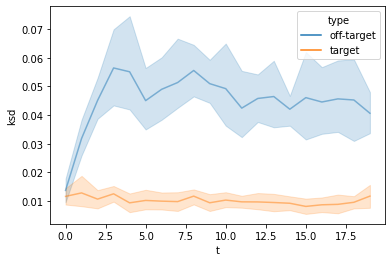

In [22]:
sns.lineplot(data=ksd_df, x="t", y="ksd", hue="type", alpha=0.5)

# Use BFGS to find the local modes

In [7]:
from src.ksd.find_modes import merge_modes

In [8]:
proposal_off.event_shape[0]

5

In [9]:
# The objective function and the gradient.
def nll_and_grad(x):
    return tfp.math.value_and_gradient(
        lambda x: -log_prob_fn(x), # minus as we want to minimise
        x)

# generate starting points
def generate_start_pts(M):
#     e1 = tf.eye(dim)[:, 0]
#     pts_list = [x * e1 for x in np.linspace(-8., 8., M)]
#     start_pts = tf.concat([pts_list], axis=1)

    unif_dist = tfp.distributions.Uniform(low=-tf.ones((dim,)), high=tf.ones((dim,)))
    start_pts = delta * unif_dist.sample(M)
    return start_pts


In [10]:
M = 10 # num of starting points
start_pts = generate_start_pts(M)  # Starting point for the search.

optim_results = tfp.optimizer.bfgs_minimize(nll_and_grad, initial_position=start_pts, tolerance=1e-8)

tf.experimental.numpy.all(optim_results.converged).numpy() # should return true

True

In [12]:
end_pts = optim_results.position # M x dim
inverse_hessian_estimate = optim_results.inverse_hessian_estimate # M x dim x dim

In [13]:
threshold = 1e-3
mode_list, inv_hess_list = merge_modes(inverse_hessian_estimate, end_pts, threshold, log_prob_fn)

In [14]:
mode_list

[<tf.Tensor: shape=(5,), dtype=float32, numpy=array([4., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([-4.000000e+00,  0.000000e+00,  5.684342e-14,  0.000000e+00,
         0.000000e+00], dtype=float32)>]

In [33]:
# use functions
import src.ksd.models as models
from src.ksd.find_modes import find_modes
tf.random.set_seed(0)

dim = 5
nstart_pts = 20 * dim
k = 1
delta = 4
threshold = 1.
ratio_target = 0.5
ratio_sample = 1.0

target, log_prob_fn = models.create_mixture_gaussian_kdim(dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_target)

In [34]:
def run_experiment(nrep, lim):
    unif_dist = tfp.distributions.Uniform(low=-tf.ones((dim,)), high=tf.ones((dim,)))
    start_pts_all = lim * unif_dist.sample((nrep, nstart_pts))
    for seed in range(nrep):
        start_pts = start_pts_all[seed, :, :]
        mode_list, _ = find_modes(start_pts, log_prob_fn, threshold=threshold)
        print(seed, len(mode_list))
    return mode_list

# Accept prob as a function of jump distance

In [56]:
tf.random.set_seed(0)

In [57]:
kernel = IMQ(med_heuristic=True)

ksd = KSD(target=target, kernel=kernel)

In [58]:
def jump_distance_experiment(nrep, proposal_off, proposal_on, steps, std_ls, dir_vec):
    ksd_df = pd.DataFrame(columns=["std", "ksd", "h1_var", "ave_accept_prob", "seed", "type"])

    iterator = trange(nrep)
    for seed in iterator:
        off_samples = proposal_off.sample(n)
        on_samples = proposal_on.sample(n)

        x_init_off = off_samples
        x_init_on = on_samples

        for i, std in enumerate(std_ls):
            iterator.set_description(f"Jump dist {i+1} of {len(std_ls)}")
            
            mh_off = RandomWalkMH(log_prob=log_prob_fn)
            mh_off.run(steps=steps, std=std, x_init=x_init_off, dir_vec=dir_vec)

            mh_on = RandomWalkMH(log_prob=log_prob_fn)
            mh_on.run(steps=steps, std=std, x_init=x_init_on, dir_vec=dir_vec)

            x_t = mh_off.x[-1, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            h1_var = ksd.h1_var(X=x_t, Y=tf.identity(x_t)).numpy()
#             ksd_val /= np.sqrt(h1_var) + 1e-8
            ave_accept_prob_off = tf.reduce_mean(mh_off.accept_prob[-1, :]).numpy()
            ksd_df.loc[len(ksd_df)] = [std, ksd_val, h1_var, ave_accept_prob_off, seed, "off-target"]
            
            x_t = mh_on.x[-1, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            h1_var = ksd.h1_var(X=x_t, Y=tf.identity(x_t)).numpy()
#             ksd_val /= np.sqrt(h1_var) + 1e-8
            ave_accept_prob_on = tf.reduce_mean(mh_on.accept_prob[-1, :]).numpy() 
            ksd_df.loc[len(ksd_df)] = [std, ksd_val, h1_var, ave_accept_prob_on, seed, "target"]
    
    return ksd_df

In [59]:
nsteps = 20
std_ls = np.linspace(0.02, 1.5, 50).tolist()
nrep = 10
dir_vec = - tf.eye(dim)[:, 0] * delta * 2

ksd_df = jump_distance_experiment(
    nrep=nrep, 
    proposal_off=proposal_off, 
    proposal_on=proposal_on, 
    steps=nsteps, 
    std_ls=std_ls,
    dir_vec=dir_vec)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='std', ylabel='ave_accept_prob'>

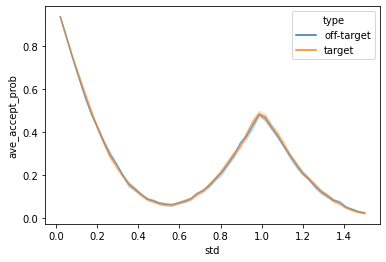

In [48]:
sns.lineplot(data=ksd_df, x="std", y="ave_accept_prob", hue="type", alpha=0.5)

<AxesSubplot:xlabel='std', ylabel='ksd'>

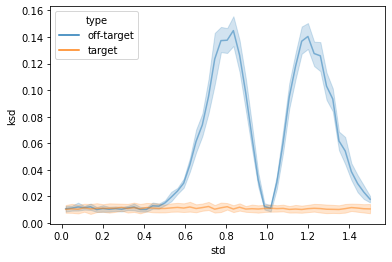

In [64]:
# ksd as a function of jump size
sns.lineplot(data=ksd_df, x="std", y="ksd", hue="type", alpha=0.5)

In [61]:
# ksd_df["ksd_orig"] = (np.sqrt(ksd_df.h1_var) + 1e-8) * ksd_df.ksd
ksd_df["h1_std"] = np.sqrt(ksd_df.h1_var)
ksd_df["ksd_scaled"] = ksd_df.ksd / (ksd_df.h1_std + 1e-8)

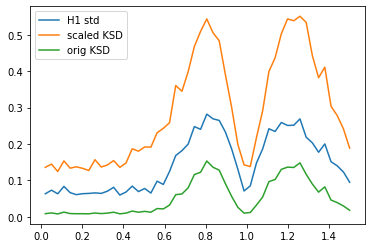

In [76]:
ksd_subdf = ksd_df.loc[(ksd_df.seed == 0) & (ksd_df.type == "off-target")]
plt.plot(ksd_subdf["std"], ksd_subdf.h1_std, label="H1 std")
plt.plot(ksd_subdf["std"], ksd_subdf.ksd_scaled, label="scaled KSD")
plt.plot(ksd_subdf["std"], ksd_subdf.ksd, label="orig KSD")
plt.legend()

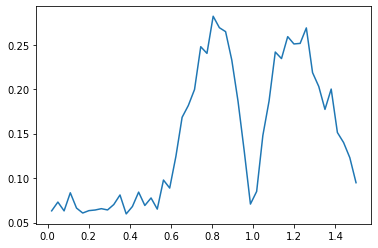

In [74]:
plt.plot(ksd_subdf["std"], ksd_subdf.ksd / ksd_subdf.ksd_scaled)

# Find the best discrete jump dist

In [58]:
def best_jump_distance_experiment(nrep, proposal_off, proposal_on, steps, std_ls, dir_vec):
    ksd_df = pd.DataFrame(columns=["std", "ksd", "ave_accept_prob", "seed", "type"])

    ntrain = int(n * 0.5)
    
    iterator = trange(nrep)
    for seed in iterator:
        for name, proposal in zip(["off-target", "target"], [proposal_off, proposal_on]):
            samples = proposal.sample(n)

            x_init = samples
            x_init_train, x_init_test = x_init[:ntrain, ], x_init[ntrain:, ]

            best_ksd = 0.
            for i, std in enumerate(std_ls):
                iterator.set_description(f"Jump dist {i+1} of {len(std_ls)}")

                # run dynamic
                mh = RandomWalkMH(log_prob=log_prob_fn)
                mh.run(steps=steps, std=std, x_init=x_init_train, dir_vec=dir_vec)
                
                # compute ksd
                x_t = mh.x[-1, :, :].numpy()
                ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
                
                if ksd_val > best_ksd:
                    best_std = std
                    best_ksd = ksd_val

            # run with test set
            mh = RandomWalkMH(log_prob=log_prob_fn)
            mh.run(steps=steps, std=best_std, x_init=x_init_test, dir_vec=dir_vec)

            x_t = mh.x[-1, :, :].numpy()
            ksd_val = ksd(x_t, tf.identity(x_t)).numpy()
            ave_accept_prob = tf.reduce_mean(mh.accept_prob[-1, :]).numpy()
            ksd_df.loc[len(ksd_df)] = [best_std, ksd_val, ave_accept_prob, seed, name]
    
    return ksd_df

In [59]:
nsteps = 20
std_ls = np.linspace(0.02, 1., 50).tolist()
nrep = 10
dir_vec = tf.eye(dim)[:, 0] * delta * 2

ksd_df = best_jump_distance_experiment(
    nrep=nrep,
    proposal_off=proposal_off,
    proposal_on=proposal_on,
    steps=nsteps,
    std_ls=std_ls,
    dir_vec=dir_vec)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='std', ylabel='Count'>

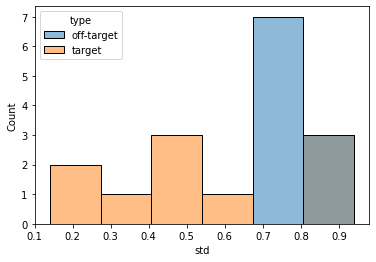

In [60]:
sns.histplot(data=ksd_df, x="std", hue="type", alpha=0.5)

# Score functions

In [60]:
delta = 20.

def score_p(x):
    numerator = - (x + delta) * np.exp(-0.5 * (x + delta)**2) - (x - delta) * np.exp(-0.5 * (x - delta)**2)
    denom = np.exp(-0.5 * (x + delta)**2) + np.exp(-0.5 * (x - delta)**2)
    return numerator / denom

def den_p(x):
    return np.log(np.exp(-0.5 * (x + delta)**2) + np.exp(-0.5 * (x - delta)**2))

def score_q(x):
    return - (x + delta)

def den_q(x):
    return -0.5 * (x + delta)**2

In [61]:
xx = np.linspace(-6, 6, 1000)

score_p_vec = score_p(xx)
score_q_vec = score_q(xx)


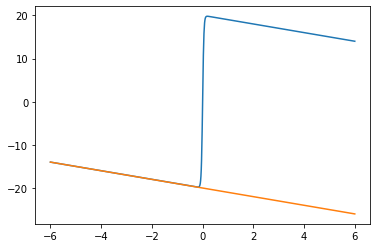

In [62]:
plt.plot(xx, score_p_vec, label="p")
plt.plot(xx, score_q_vec, label="q")

40.0


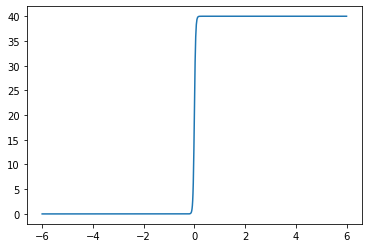

In [76]:
# plt.plot(xx, 2 * delta / (np.exp(- 2 * xx * delta) + 1), label="analytical diff")
# plt.plot(xx, score_p_vec - score_q_vec, label="numerical diff")

xx_neg = xx < 100
diff = (score_p_vec - score_q_vec)[xx_neg]
print(max(diff))
plt.plot(xx[xx_neg], diff)

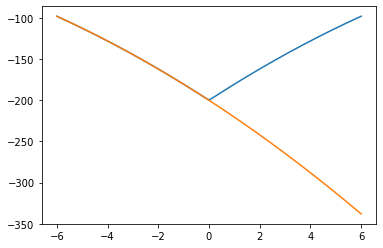

In [73]:
den_p_vec = den_p(xx)
den_q_vec = den_q(xx)

plt.plot(xx, den_p_vec, label="p")
plt.plot(xx, den_q_vec, label="q")

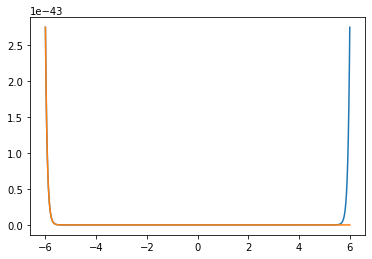

In [74]:
plt.plot(xx, np.exp(den_p_vec), label="p")
plt.plot(xx, np.exp(den_q_vec), label="q")

# Test numerically if Stein's identity holds on the perturbed $p$

In [3]:
def log_trans_q(x, log_q_fn, log_p_fn, std, dir_vec):
    """Density of q after 1 step of Markov transition"""
    term1, term2, term1_del = 0., 0., 0.
    p_x = tf.exp(log_p_fn(x)) # n
    q_x = tf.exp(log_q_fn(x)) # n

    for xp in [x + std*dir_vec, x - std*dir_vec]:
        p_xp = tf.exp(log_p_fn(xp))
        q_xp = tf.exp(log_q_fn(xp))

        term1 += q_xp * tf.math.minimum(1, p_x / p_xp)
        term2 += q_x * (1 - tf.math.minimum(1, p_xp / p_x))
    
    den = tf.math.log(term1 + term2) # n
    
    return den

In [10]:
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ
import src.ksd.models as models
from src.ksd.langevin import RandomWalkMH
import src.ksd.langevin as MCMC
from src.ksd.find_modes import find_modes, pairwise_directions
tf.random.set_seed(0)

In [5]:
dim = 5
ratio_target = 0.5
ratio_sample = 1.
k = 1
delta = 4.
n = 500

target, log_prob_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_target)
proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_sample)

2022-03-01 09:22:03.321314: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-01 09:22:03.864859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:b1:00.0, compute capability: 7.5


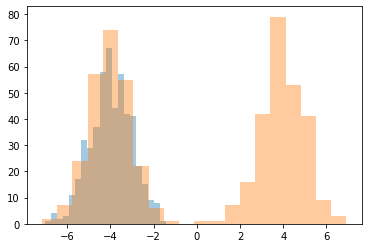

In [6]:
off_samples = proposal_off.sample(n)
on_samples = target.sample(n)

_ = plt.hist(off_samples.numpy()[:, 0], bins=20, label="off-target", alpha=0.4)
_ = plt.hist(on_samples.numpy()[:, 0], bins=20, label="target", alpha=0.4)

In [7]:
# between-modes vector
dir_vec = - tf.eye(dim)[:, 0] * delta * 2
best_std_off = 0.8

In [8]:
# log prob of perturbed q
log_trans_q_off = lambda x: log_trans_q(x, log_prob_off_fn, log_prob_fn, best_std_off, dir_vec)
class PerturbedQ:
    def __init__(self):
        pass
    def log_prob(self, x):
        return log_trans_q_off(x)

In [ ]:
mode1 = 

proposal_dict = mcmc.prepare_proposal_input(
    mode1=mode1, mode2=mode2, hess1_inv=hess1_inv, hess2_inv=hess2_inv)

In [9]:
# sample from perturbed q
T = 2
mh_off = RandomWalkMH(log_prob=log_prob_fn)
mh_off.run(steps=T, std=best_std_off, x_init=off_samples, dir_vec=dir_vec)
off_samples_pert = mh_off.x[-1, :, :]

UnboundLocalError: local variable 'log_det_jacobian' referenced before assignment

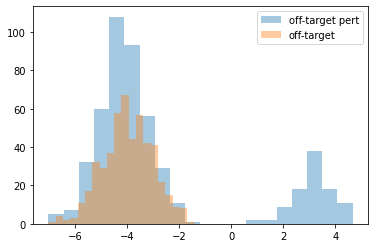

In [292]:
_ = plt.hist(mh_off.x[-1, :, 0].numpy(), bins=20, label="off-target pert", alpha=0.4)
_ = plt.hist(off_samples.numpy()[:, 0], bins=20, label="off-target", alpha=0.4)
plt.legend()

In [293]:
# compute ksd
imq = IMQ(med_heuristic=True)
ksd = KSD(target=PerturbedQ(), kernel=imq)
ksd(off_samples_pert, tf.identity(off_samples_pert)).numpy()

0.013808735

In [294]:
# PerturbedQ().log_prob(off_samples_pert)

<AxesSubplot:xlabel='x0', ylabel='prob'>

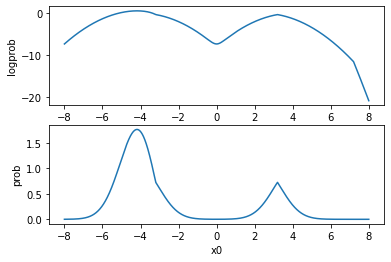

In [295]:
# log prob of 1-step mh-perturbed densities        
xx = tf.concat(
    [tf.reshape(tf.linspace(-2*delta, 2*delta, 5000), (-1, 1)), tf.zeros((5000, dim-1))],
    axis=1) # 200 x dim

log_prob_trans_off = log_trans_q_off(xx).numpy()
prob_trans_off = np.exp(log_prob_trans_off)
log_prob_trans_off_df = pd.DataFrame(
    {"logprob": log_prob_trans_off, "x0": xx[:, 0].numpy(), "prob": prob_trans_off})

plt.subplot(2, 1, 1)
sns.lineplot(data=log_prob_trans_off_df, x="x0", y="logprob")
plt.subplot(2, 1, 2)
sns.lineplot(data=log_prob_trans_off_df, x="x0", y="prob")

In [297]:
def run_experiment(nlist):
    
    T = 1
    mh_off = RandomWalkMH(log_prob=log_prob_fn) # perturb according to p
    imq = IMQ(med_heuristic=True)
    ksd = KSD(target=PerturbedQ(), kernel=imq)

    ksd_res = []
    for n in tqdm(nlist):
        off_samples = proposal_off.sample(n)
        mh_off.run(steps=T, std=best_std_off, x_init=off_samples, dir_vec=dir_vec)
        off_samples_pert = mh_off.x[-1, :, :]
        
        # compute ksd
        ksd_val = ksd(off_samples_pert, tf.identity(off_samples_pert)).numpy()
        ksd_res.append(ksd_val)
        
    res = pd.DataFrame({"n": nlist, "ksd": ksd_res})
    return res

In [298]:
nlist = [100, 250, 500, 750, 1000, 2000, 3000]
res = run_experiment(nlist)

  0%|          | 0/7 [00:00<?, ?it/s]

<AxesSubplot:xlabel='n', ylabel='ksd'>

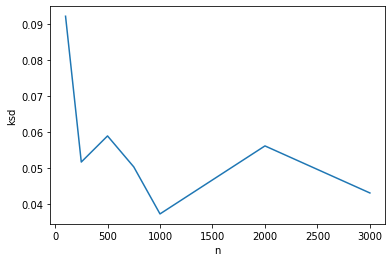

In [299]:
sns.lineplot(data=res, x="n", y="ksd")